In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def organizeData():
    # Retrieves csv
    df = pd.read_csv("./pokedex.csv")
    # Splits the 'type' column in 2, and makes a new column 'primary_type' which stores the first type
    split_types = df['type'].str.strip('{}').str.split(',', n = 1, expand = True)
    df['primary_type'] = split_types[0].str.strip()
    # Only keeps the stats and the primary type
    df = df[['hp', 'attack', 'defense', 's_attack', 's_defense', 'speed', 'primary_type']]
    # Capitalizes the first letter of the primary type (usefulf for later)
    df['primary_type'] = df['primary_type'].str.capitalize()
    return df

In [37]:
df = organizeData()
df

hp  attack  defense  s_attack  s_defense  speed primary_type
0      45      49       49        65         65     45        Grass
1      60      62       63        80         80     60        Grass
2      80      82       83       100        100     80        Grass
3      39      52       43        60         50     65         Fire
4      58      64       58        80         65     80         Fire
...   ...     ...      ...       ...        ...    ...          ...
1020  125      73       91       137         89     75     Electric
1021   90     120       80        68        108    124         Rock
1022   90      72      100       122        108     98        Steel
1023   90      65       85        65         85     60       Normal
1024   88      88      160        88         88     88       Poison

[1025 rows x 7 columns]

In [ ]:
# Preprocessing the data always utilizes the label encoder to convert our primary type labels into numeric values
# When oversampling, the RandomOverSampler is used on the data too
# When Normalizing, the Standard Scaler is used on the data too
def preprocess_data(df, method):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['primary_type'])
    X = df[['hp', 'attack', 'defense', 's_attack', 's_defense', 'speed']].values

    if method == "none":
        return X, y, label_encoder
    elif method == "oversample":
        ros = RandomOverSampler()
        X_resampled, y_resampled = ros.fit_resample(X, y)
        return X_resampled, y_resampled, label_encoder
    elif method == "normalize+oversample":
        X_scaled = StandardScaler().fit_transform(X)
        ros = RandomOverSampler()
        X_resampled, y_resampled = ros.fit_resample(X_scaled, y)
        return X_resampled, y_resampled, label_encoder

In [ ]:
# Shows the distribution of the different labels (primary types) in the data provided
def plot_type_distribution(df, title):
    primary_type_order = ['Water', 'Normal', 'Grass', 'Bug', 'Psychic', 'Electric', 'Rock', 'Fire',
                     'Dark', 'Poison', 'Ground', 'Ghost', 'Fighting', 'Ice', 'Dragon', 'Steel',
                     'Fairy', 'Flying']

    type_color_palette = {'None':'powderblue',
                    'Flying':'lavender',
                    'Fairy':'pink',
                    'Psychic':'magenta',
                    'Poison':'darkviolet',
                    'Ground':'peru',
                    'Steel':'silver',
                    'Dragon':'royalblue',
                    'Fighting':'darkorange',
                    'Dark':'black',
                    'Grass':'limegreen',
                    'Ghost':'thistle',
                    'Water':'blue',
                    'Ice':'cyan',
                    'Fire':'red',
                    'Rock':'saddlebrown',
                    'Electric':'yellow',
                    'Normal':'linen',
                    'Bug':'greenyellow'}

    counts = df['primary_type'].value_counts()
    type_sizes = [counts.get(pt, 0) for pt in primary_type_order]
    colors = [type_color_palette[pt] for pt in primary_type_order]
    plt.figure(figsize = (10, 4))
    sns.barplot(x = primary_type_order, y=type_sizes, palette = colors)
    plt.title(title)
    plt.xlabel("Primary Type")
    plt.ylabel("Count")
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_8504/1948970162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_order, y=sizes, palette=colors)


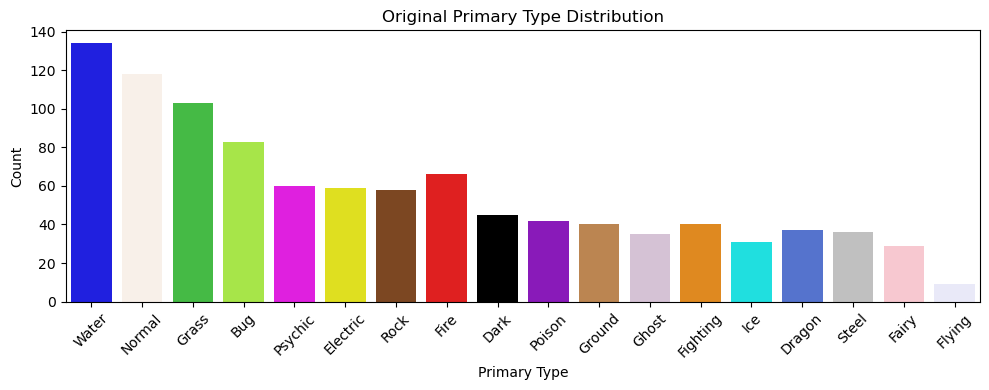

/tmp/ipykernel_8504/1948970162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_order, y=sizes, palette=colors)


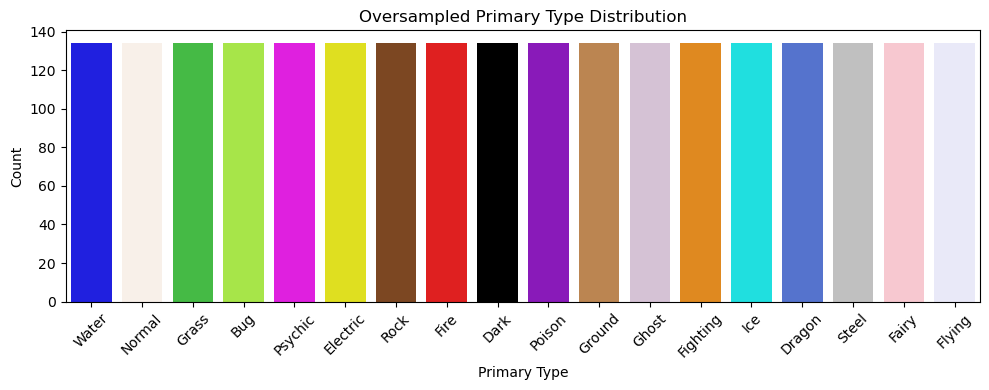

/tmp/ipykernel_8504/1948970162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_order, y=sizes, palette=colors)


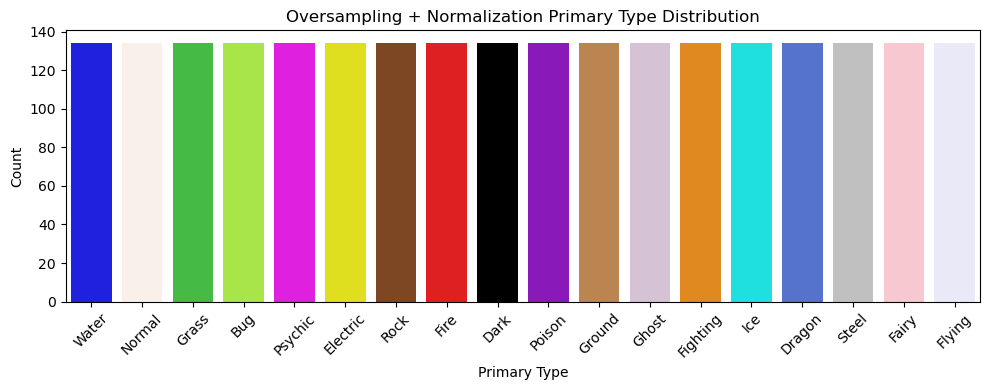

In [40]:
# Original data
x1, y1, label_encoder1 = preprocess_data(df, "none")
df1 = pd.DataFrame(x1, columns=['hp', 'attack', 'defense', 's_attack', 's_defense', 'speed'])
df1['primary_type'] = label_encoder1.inverse_transform(y1)
plot_type_distribution(df1, title="Original Primary Type Distribution")

# Oversampled data
x2, y2, label_encoder2 = preprocess_data(df, "oversample")
df2 = pd.DataFrame(x2, columns=['hp', 'attack', 'defense', 's_attack', 's_defense', 'speed'])
df2['primary_type'] = label_encoder2.inverse_transform(y2)
plot_type_distribution(df2, title="Oversampled Primary Type Distribution")

# Oversampled + Normalized
x3, y3, label_encoder3 = preprocess_data(df, "normalize+oversample")
df3 = pd.DataFrame(x3, columns=['hp', 'attack', 'defense', 's_attack', 's_defense', 'speed'])
df3['primary_type'] = label_encoder3.inverse_transform(y3)
plot_type_distribution(df3, title="Oversampling + Normalization Primary Type Distribution")

In [ ]:
# Building the model, different optimizers can be selected based on input
# Sparse categorical crossentropy used for loss since we have numeric labels
def build_model(optimizer_name, input_shape):
    optimizers = {
        "sgd": keras.optimizers.SGD(),
        "sgd_momentum": keras.optimizers.SGD(momentum=0.9),
        "adam": keras.optimizers.Adam(),
        "adagrad": keras.optimizers.Adagrad(),
        "rmsprop": keras.optimizers.RMSprop()
    }
    optimizer = optimizers[optimizer_name]

    model = keras.Sequential([
        keras.Input(shape = (input_shape,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(18, activation='softmax')
    ])
    model.compile(optimizer = optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# Performs the train test split on the data, 20% testing data and 80% training data
# By default this is over 500 epochs, and the validation split is 10% of the training data
def train_and_evaluate(model, X, y, label_encoder, title_suffix = "", numEpochs = 500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    history = model.fit(X_train, y_train, batch_size = 64, epochs = numEpochs, validation_split = 0.1, verbose = 1)

    # Accuracy graph
    plt.figure(figsize = (6, 4))
    plt.plot(history.history['accuracy'], label = 'Train Acc')
    plt.plot(history.history['val_accuracy'], label = 'Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.legend()
    plt.show()

    # Loss graph
    plt.figure(figsize = (6, 4))
    plt.plot(history.history['loss'], label = 'Train Loss', color = 'black')
    plt.plot(history.history['val_loss'], label = 'Val Loss', color = 'maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Trajectory {title_suffix}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot=True, fmt = 'd', xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f'Confusion Matrix {title_suffix}')
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred_classes, output_dict = True, target_names = label_encoder.classes_)
    print(classification_report(y_test, y_pred_classes, target_names = label_encoder.classes_))

    # Graph for Precision, Recall, and F1 Score
    classes = list(label_encoder.classes_)
    x = np.arange(len(classes))
    precision_vals = [report[i]['precision'] for i in classes]
    recall_vals = [report[j]['recall'] for j in classes]
    f1_vals = [report[k]['f1-score'] for k in classes]
    plt.figure(figsize = (14, 6))
    plt.bar(x - 0.25, precision_vals, 0.25, label = 'Precision')
    plt.bar(x, recall_vals, 0.25, label = 'Recall')
    plt.bar(x + 0.25, f1_vals, 0.25, label = 'F1-Score')
    plt.xticks(x, classes, rotation = 45)
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1-Score per Class {title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()  

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0581 - loss: 22.2407 - val_accuracy: 0.0976 - val_loss: 4.1046
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0858 - loss: 8.1073 - val_accuracy: 0.1341 - val_loss: 2.8713
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0695 - loss: 5.2152 - val_accuracy: 0.1463 - val_loss: 2.8654
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0739 - loss: 3.8081 - val_accuracy: 0.1829 - val_loss: 2.8535
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0969 - loss: 3.3650 - val_accuracy: 0.1220 - val_loss: 2.8605
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1256 - loss: 3.1137 - val_accuracy: 0.0976 - val_loss: 2.8669
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1075 - loss: 2.9883 - val_accuracy: 0.1098 - val_loss: 2.8648
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1057 - loss: 3.0464 - val_accuracy: 0.1

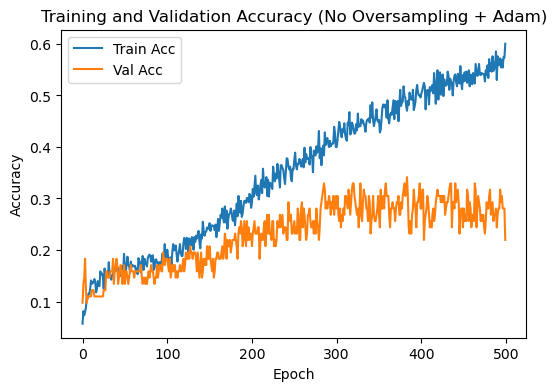

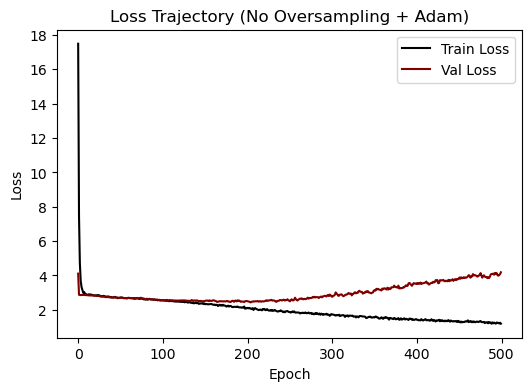

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


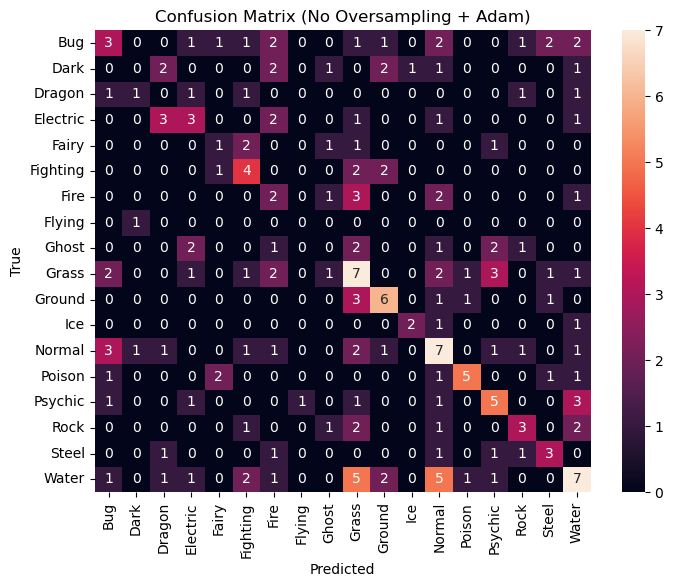

              precision    recall  f1-score   support

         Bug       0.25      0.18      0.21        17
        Dark       0.00      0.00      0.00        10
      Dragon       0.00      0.00      0.00         6
    Electric       0.30      0.27      0.29        11
       Fairy       0.20      0.17      0.18         6
    Fighting       0.31      0.44      0.36         9
        Fire       0.14      0.22      0.17         9
      Flying       0.00      0.00      0.00         1
       Ghost       0.00      0.00      0.00         9
       Grass       0.23      0.32      0.27        22
      Ground       0.43      0.50      0.46        12
         Ice       0.67      0.50      0.57         4
      Normal       0.26      0.35      0.30        20
      Poison       0.62      0.45      0.53        11
     Psychic       0.36      0.38      0.37        13
        Rock       0.38      0.30      0.33        10
       Steel       0.38      0.38      0.38         8
       Water       0.32    

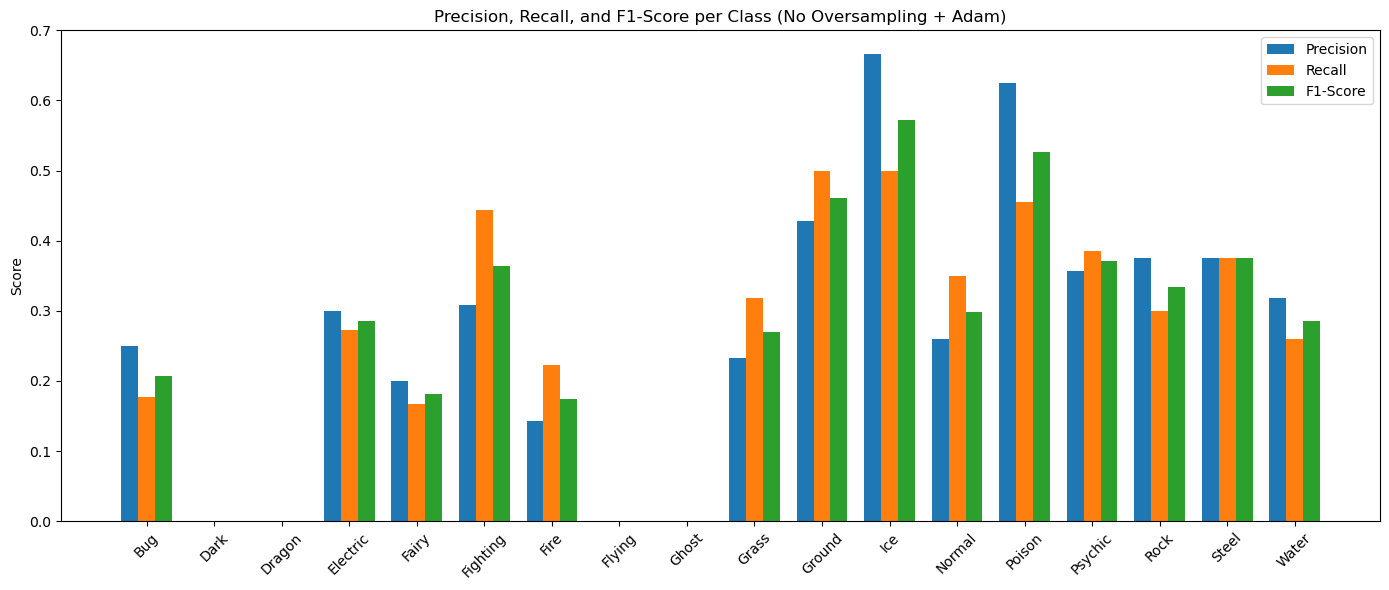

In [ ]:
# Model for no oversampling and adam optimizer
model = build_model(optimizer_name = "adam", input_shape = x1.shape[1])
train_and_evaluate(model, x1, y1, label_encoder1, title_suffix = "(No Oversampling + Adam)")

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0567 - loss: 18.4006 - val_accuracy: 0.0777 - val_loss: 3.0392
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0622 - loss: 4.8397 - val_accuracy: 0.1244 - val_loss: 2.7976
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0856 - loss: 3.4594 - val_accuracy: 0.1088 - val_loss: 2.7959
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0732 - loss: 3.2146 - val_accuracy: 0.1606 - val_loss: 2.7816
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0726 - loss: 3.0420 - val_accuracy: 0.1140 - val_loss: 2.8160
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0772 - loss: 2.9830 - val_accuracy: 0.1192 - val_loss: 2.8180
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0797 - loss: 2.9418 - val_accuracy: 0.1295 - val_loss: 2.8073
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0856 - loss: 2.8723 - val_accuracy: 0.1140 -

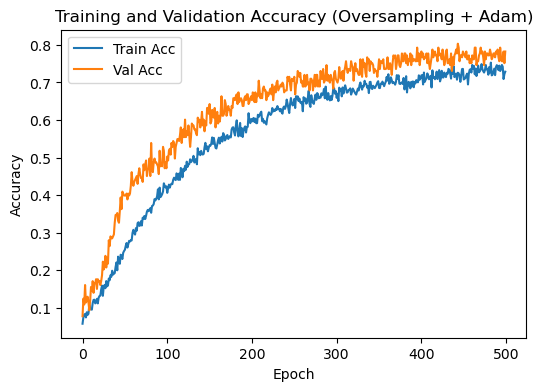

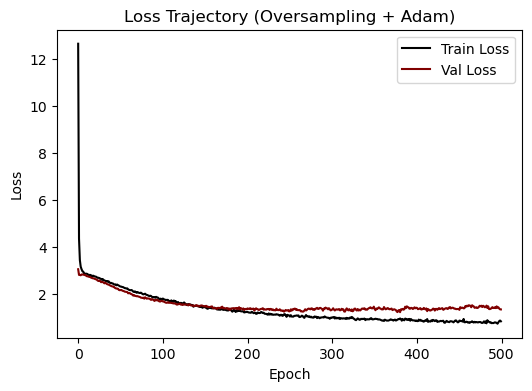

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


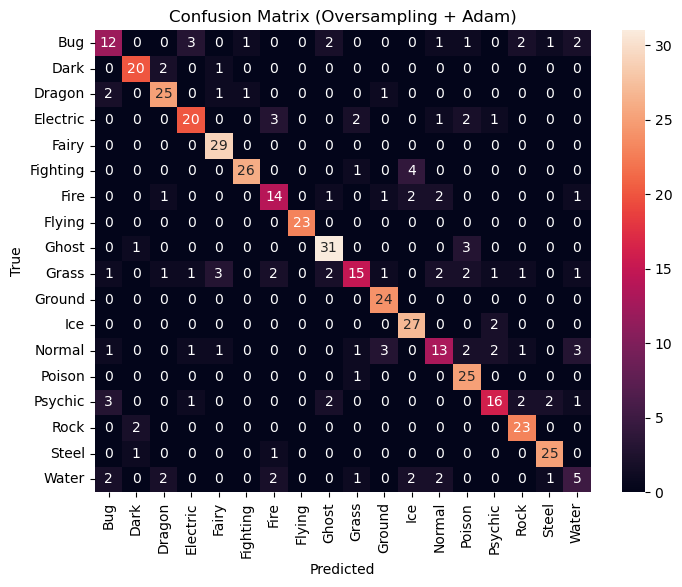

              precision    recall  f1-score   support

         Bug       0.57      0.48      0.52        25
        Dark       0.83      0.87      0.85        23
      Dragon       0.81      0.83      0.82        30
    Electric       0.77      0.69      0.73        29
       Fairy       0.83      1.00      0.91        29
    Fighting       0.93      0.84      0.88        31
        Fire       0.64      0.64      0.64        22
      Flying       1.00      1.00      1.00        23
       Ghost       0.82      0.89      0.85        35
       Grass       0.71      0.45      0.56        33
      Ground       0.80      1.00      0.89        24
         Ice       0.77      0.93      0.84        29
      Normal       0.62      0.46      0.53        28
      Poison       0.71      0.96      0.82        26
     Psychic       0.73      0.59      0.65        27
        Rock       0.79      0.92      0.85        25
       Steel       0.86      0.93      0.89        27
       Water       0.38    

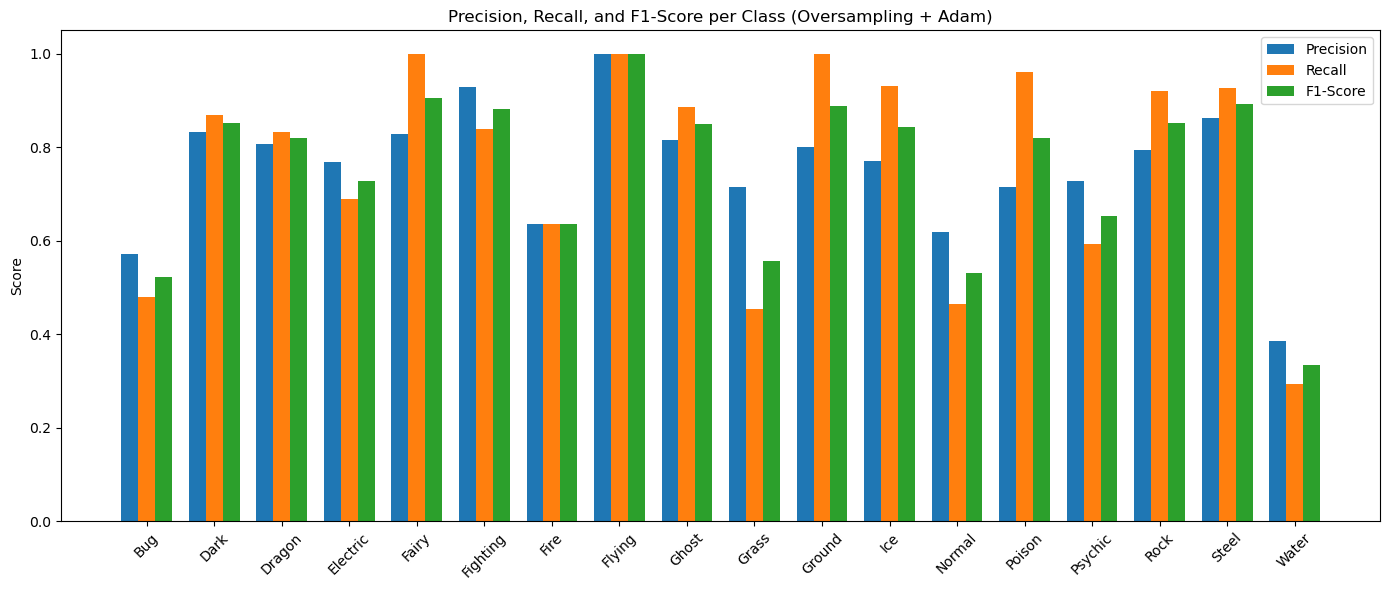

In [ ]:
# Model for oversampling and adam optimizer
model = build_model(optimizer_name = "adam", input_shape = x2.shape[1])
train_and_evaluate(model, x2, y2, label_encoder2, title_suffix = "(Oversampling + Adam)")

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0714 - loss: 2.8808 - val_accuracy: 0.1762 - val_loss: 2.7957
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1252 - loss: 2.7952 - val_accuracy: 0.1710 - val_loss: 2.6694
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1501 - loss: 2.6888 - val_accuracy: 0.2332 - val_loss: 2.5377
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1697 - loss: 2.5938 - val_accuracy: 0.1969 - val_loss: 2.4496
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1843 - loss: 2.5638 - val_accuracy: 0.2487 - val_loss: 2.4088
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1761 - loss: 2.5050 - val_accuracy: 0.2642 - val_loss: 2.3611
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2092 - loss: 2.4540 - val_accuracy: 0.2694 - val_loss: 2.3265
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1954 - loss: 2.4263 - val_accuracy: 0.2953 - 

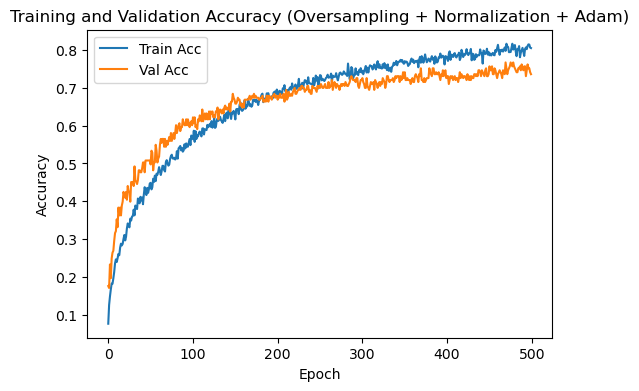

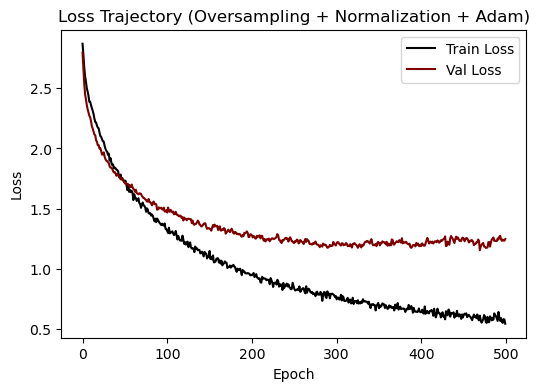

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


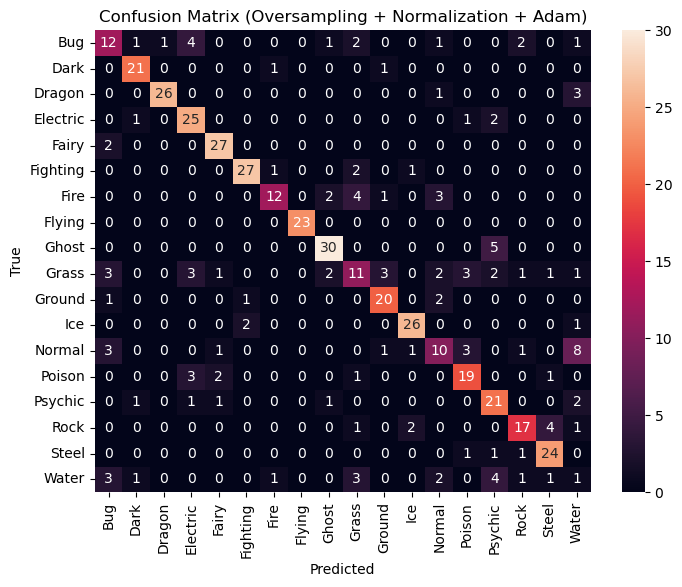

              precision    recall  f1-score   support

         Bug       0.50      0.48      0.49        25
        Dark       0.84      0.91      0.88        23
      Dragon       0.96      0.87      0.91        30
    Electric       0.69      0.86      0.77        29
       Fairy       0.84      0.93      0.89        29
    Fighting       0.90      0.87      0.89        31
        Fire       0.80      0.55      0.65        22
      Flying       1.00      1.00      1.00        23
       Ghost       0.83      0.86      0.85        35
       Grass       0.46      0.33      0.39        33
      Ground       0.77      0.83      0.80        24
         Ice       0.87      0.90      0.88        29
      Normal       0.48      0.36      0.41        28
      Poison       0.70      0.73      0.72        26
     Psychic       0.60      0.78      0.68        27
        Rock       0.74      0.68      0.71        25
       Steel       0.77      0.89      0.83        27
       Water       0.06    

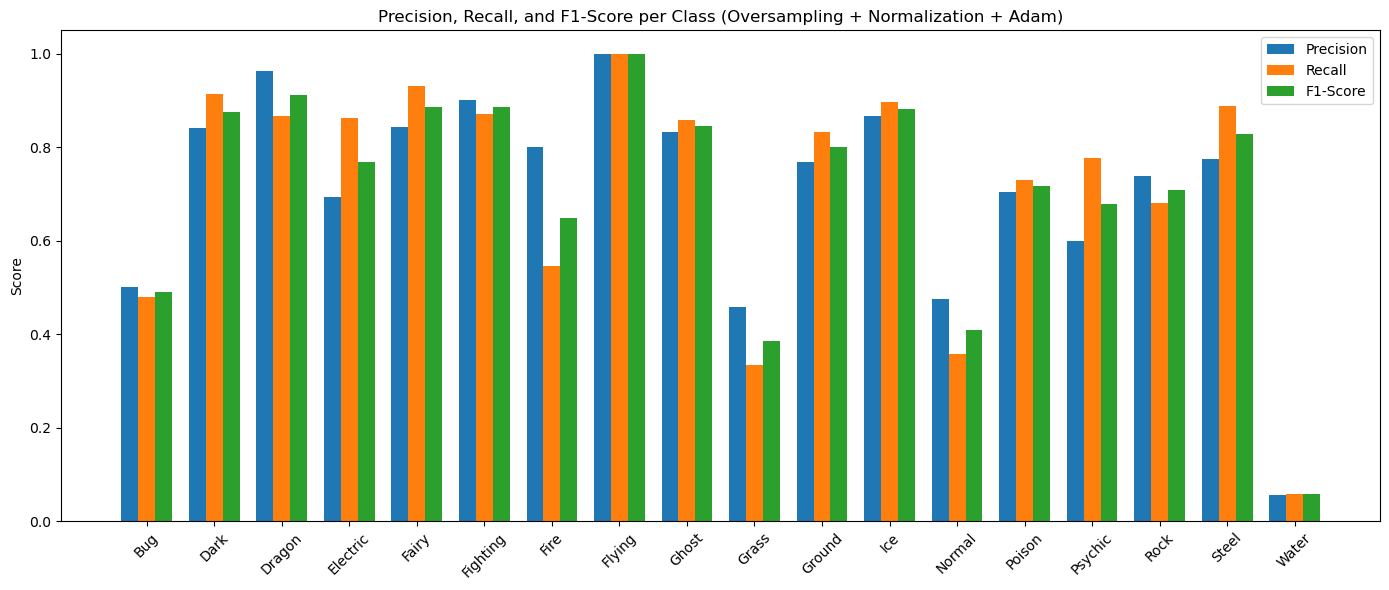

In [ ]:
# Model for oversampling and normalization and adam optimizer
model = build_model(optimizer_name = "adam", input_shape = x3.shape[1])
train_and_evaluate(model, x3, y3, label_encoder3, title_suffix = "(Oversampling + Normalization + Adam)")

Since we have established that preprocessing with oversampling and normalization is CLEARLY the best for results, we continue with that while testing other versions of the model.

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0559 - loss: 2.9029 - val_accuracy: 0.0466 - val_loss: 2.8993
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0629 - loss: 2.8963 - val_accuracy: 0.0622 - val_loss: 2.8933
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0574 - loss: 2.8928 - val_accuracy: 0.0570 - val_loss: 2.8885
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0801 - loss: 2.8917 - val_accuracy: 0.0570 - val_loss: 2.8832
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0754 - loss: 2.8804 - val_accuracy: 0.0622 - val_loss: 2.8784
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0732 - loss: 2.8766 - val_accuracy: 0.0674 - val_loss: 2.8738
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0748 - loss: 2.8759 - val_accuracy: 0.0725 - val_loss: 2.8691
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0734 - loss: 2.8748 - val_accuracy: 0.0777 - 

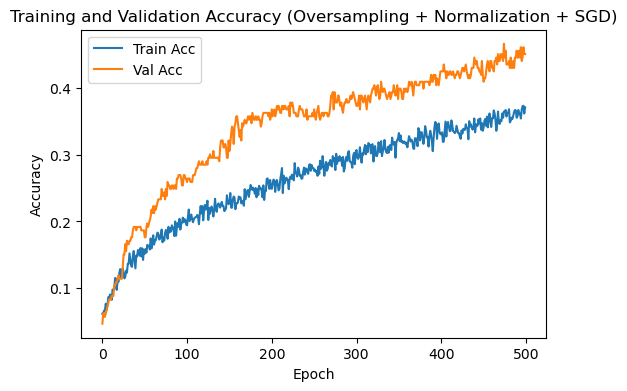

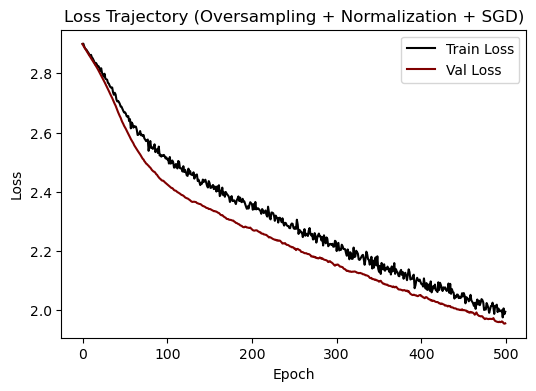

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


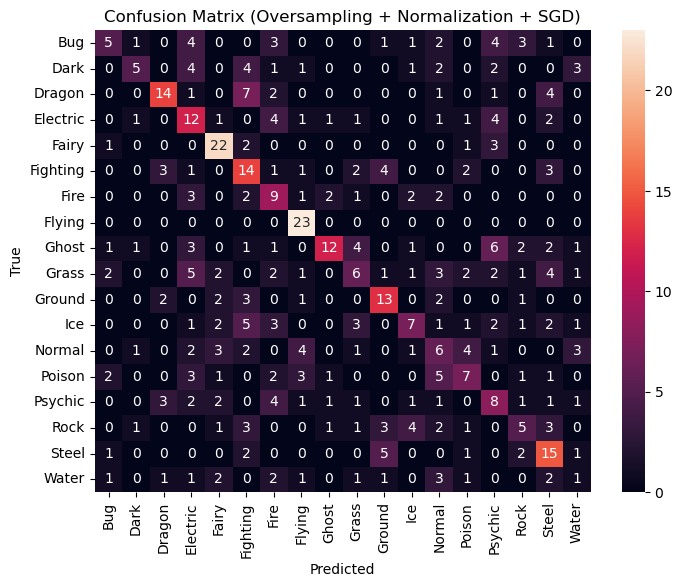

              precision    recall  f1-score   support

         Bug       0.38      0.20      0.26        25
        Dark       0.50      0.22      0.30        23
      Dragon       0.61      0.47      0.53        30
    Electric       0.29      0.41      0.34        29
       Fairy       0.58      0.76      0.66        29
    Fighting       0.31      0.45      0.37        31
        Fire       0.26      0.41      0.32        22
      Flying       0.61      1.00      0.75        23
       Ghost       0.67      0.34      0.45        35
       Grass       0.29      0.18      0.22        33
      Ground       0.46      0.54      0.50        24
         Ice       0.37      0.24      0.29        29
      Normal       0.19      0.21      0.20        28
      Poison       0.33      0.27      0.30        26
     Psychic       0.24      0.30      0.27        27
        Rock       0.29      0.20      0.24        25
       Steel       0.38      0.56      0.45        27
       Water       0.08    

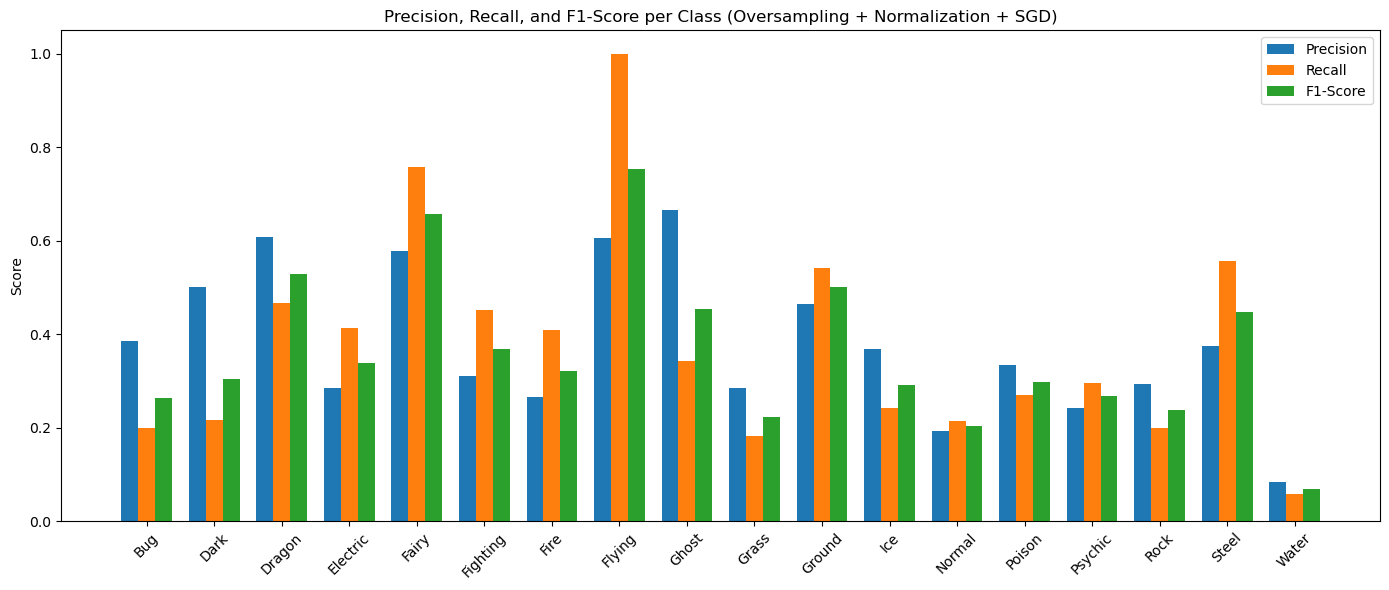

In [ ]:
# The model above uses adam with oversampling and normalization, so it will be used to compare with the following models:
# This model is SGD with oversampling and normalization
model = build_model(optimizer_name = "sgd", input_shape = x3.shape[1])
train_and_evaluate(model, x3, y3, label_encoder3, title_suffix = "(Oversampling + Normalization + SGD)")

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0667 - loss: 2.9147 - val_accuracy: 0.0674 - val_loss: 2.8757
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0706 - loss: 2.8747 - val_accuracy: 0.1192 - val_loss: 2.8376
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0967 - loss: 2.8347 - val_accuracy: 0.1917 - val_loss: 2.7780
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1125 - loss: 2.7872 - val_accuracy: 0.1606 - val_loss: 2.7213
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1318 - loss: 2.7497 - val_accuracy: 0.1710 - val_loss: 2.6503
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1512 - loss: 2.6973 - val_accuracy: 0.1813 - val_loss: 2.5970
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1803 - loss: 2.6416 - val_accuracy: 0.1969 - val_loss: 2.5399
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1633 - loss: 2.6155 - val_accuracy: 0.1917 - 

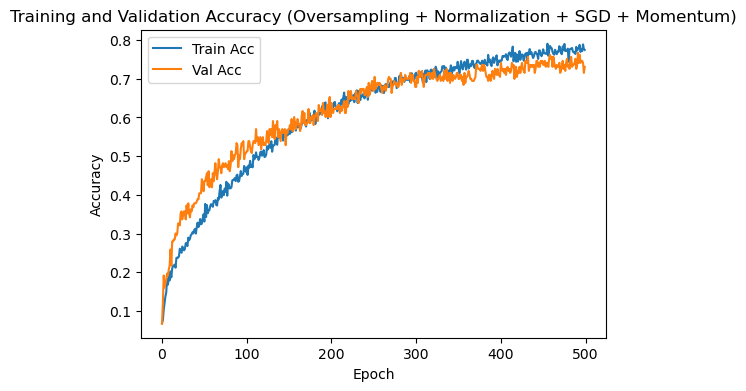

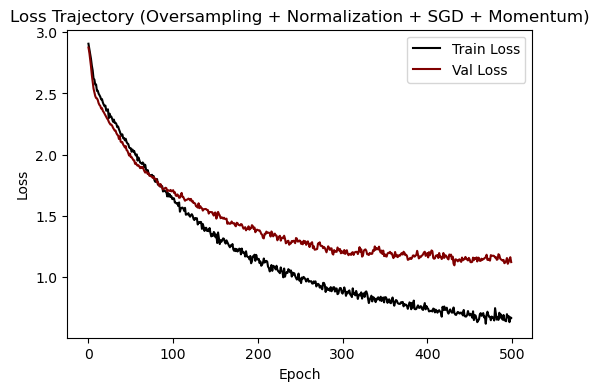

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


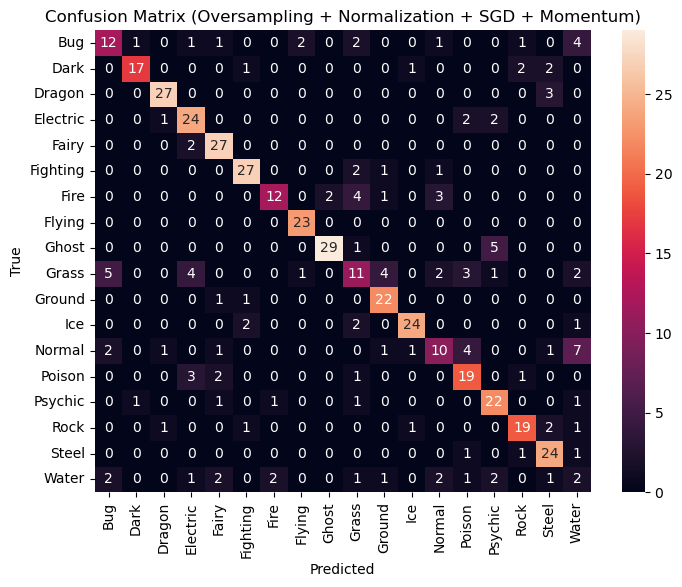

              precision    recall  f1-score   support

         Bug       0.57      0.48      0.52        25
        Dark       0.89      0.74      0.81        23
      Dragon       0.90      0.90      0.90        30
    Electric       0.69      0.83      0.75        29
       Fairy       0.77      0.93      0.84        29
    Fighting       0.84      0.87      0.86        31
        Fire       0.80      0.55      0.65        22
      Flying       0.88      1.00      0.94        23
       Ghost       0.94      0.83      0.88        35
       Grass       0.44      0.33      0.38        33
      Ground       0.73      0.92      0.81        24
         Ice       0.89      0.83      0.86        29
      Normal       0.53      0.36      0.43        28
      Poison       0.63      0.73      0.68        26
     Psychic       0.69      0.81      0.75        27
        Rock       0.79      0.76      0.78        25
       Steel       0.73      0.89      0.80        27
       Water       0.11    

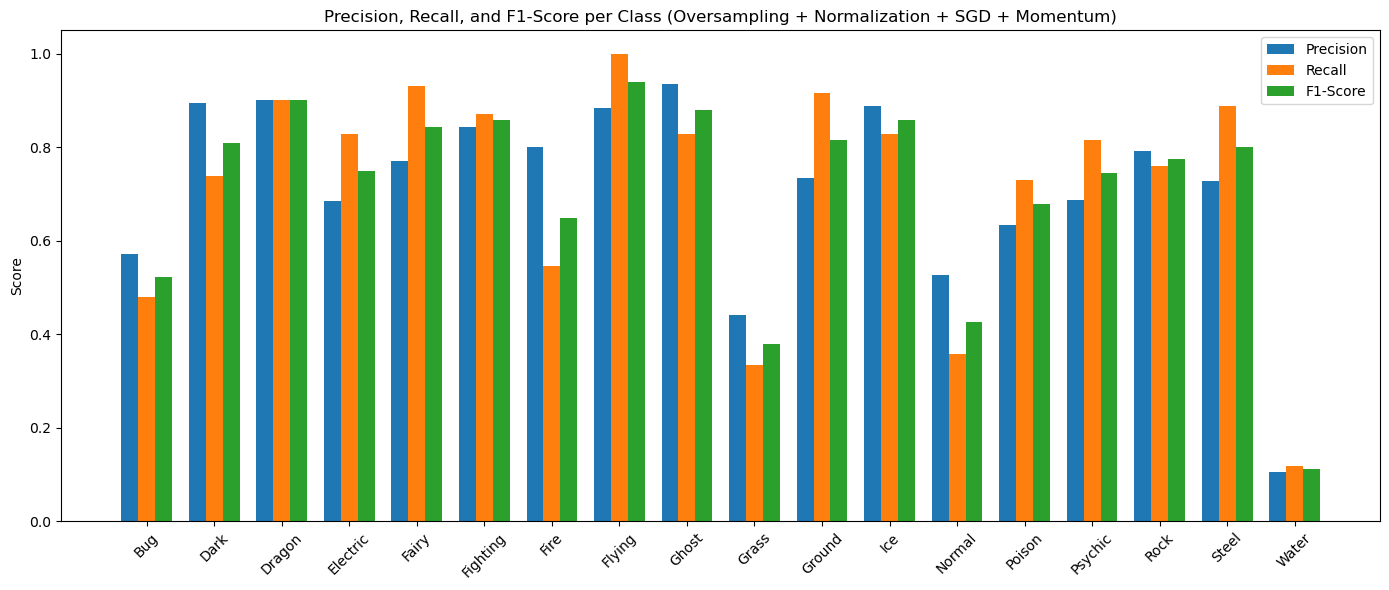

In [ ]:
# Model for oversampling and normalization with SGD momentum
model = build_model(optimizer_name = "sgd_momentum", input_shape = x3.shape[1])
train_and_evaluate(model, x3, y3, label_encoder3, title_suffix = "(Oversampling + Normalization + SGD + Momentum)")

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0664 - loss: 2.9130 - val_accuracy: 0.0570 - val_loss: 2.8991
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0567 - loss: 2.9097 - val_accuracy: 0.0725 - val_loss: 2.8965
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0572 - loss: 2.9068 - val_accuracy: 0.0777 - val_loss: 2.8942
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0514 - loss: 2.9025 - val_accuracy: 0.0933 - val_loss: 2.8921
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0623 - loss: 2.9072 - val_accuracy: 0.0933 - val_loss: 2.8899
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0595 - loss: 2.9065 - val_accuracy: 0.1036 - val_loss: 2.8878
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0639 - loss: 2.8916 - val_accuracy: 0.1088 - val_loss: 2.8858
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0594 - loss: 2.9073 - val_accuracy: 0.1140 - 

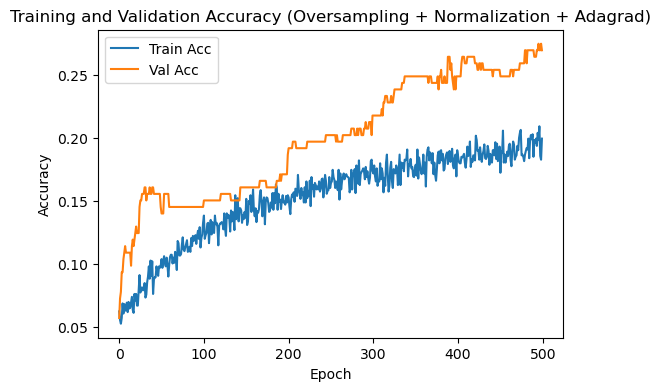

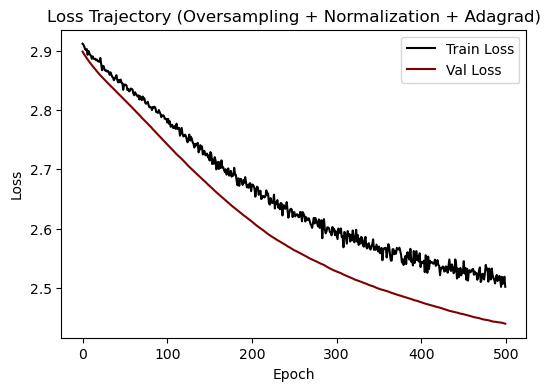

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


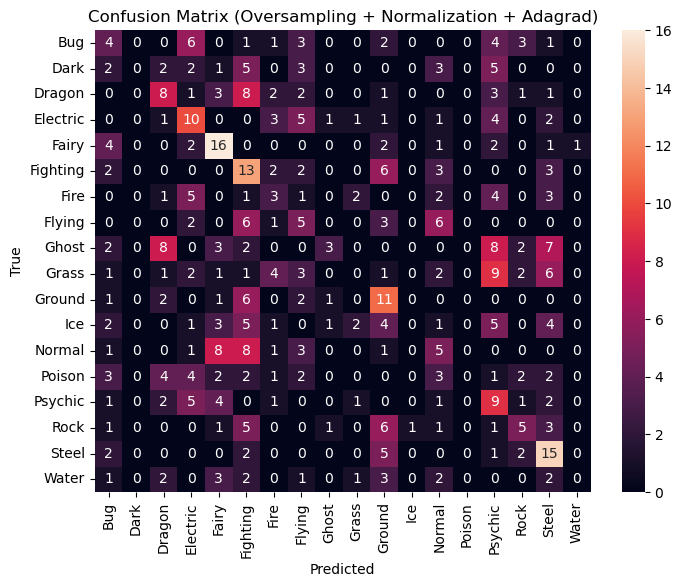

/home/kyogrekube/miniconda3/envs/cognitive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kyogrekube/miniconda3/envs/cognitive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kyogrekube/miniconda3/envs/cognitive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

         Bug       0.15      0.16      0.15        25
        Dark       0.00      0.00      0.00        23
      Dragon       0.26      0.27      0.26        30
    Electric       0.24      0.34      0.29        29
       Fairy       0.35      0.55      0.43        29
    Fighting       0.19      0.42      0.27        31
        Fire       0.15      0.14      0.14        22
      Flying       0.16      0.22      0.18        23
       Ghost       0.43      0.09      0.14        35
       Grass       0.00      0.00      0.00        33
      Ground       0.24      0.46      0.31        24
         Ice       0.00      0.00      0.00        29
      Normal       0.16      0.18      0.17        28
      Poison       0.00      0.00      0.00        26
     Psychic       0.16      0.33      0.22        27
        Rock       0.28      0.20      0.23        25
       Steel       0.29      0.56      0.38        27
       Water       0.00    

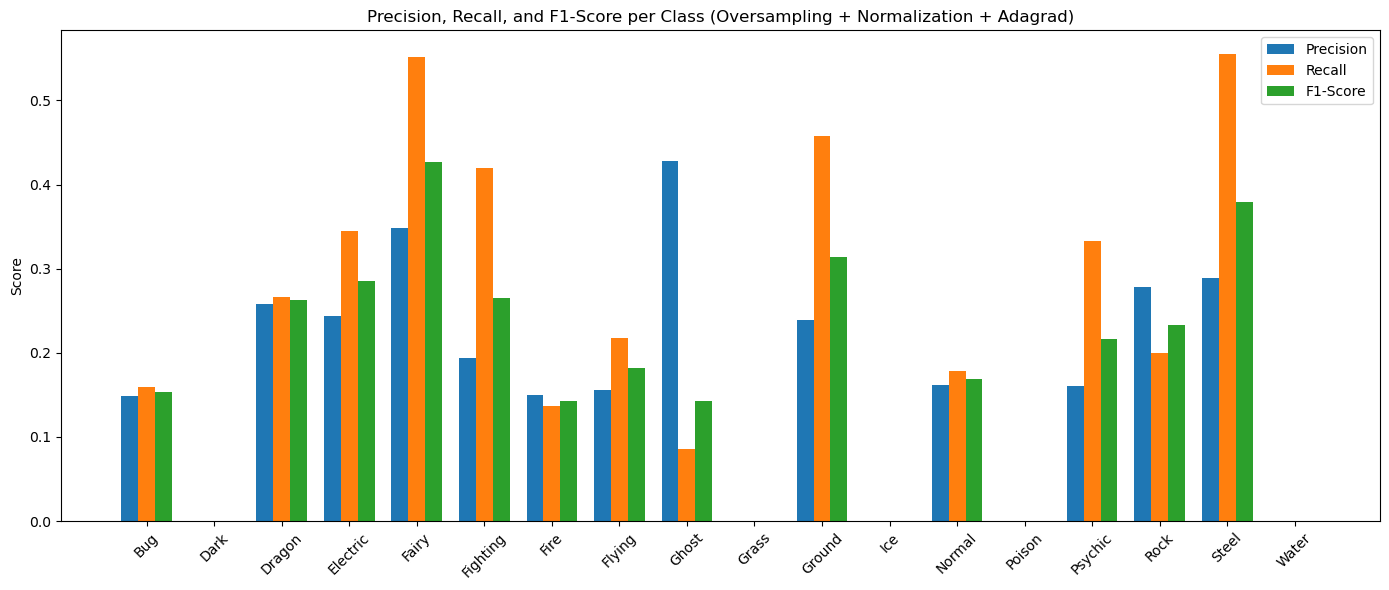

In [ ]:
# Model for oversampling and normalization with Adagrad
model = build_model(optimizer_name = "adagrad", input_shape = x3.shape[1])
train_and_evaluate(model, x3, y3, label_encoder3, title_suffix = "(Oversampling + Normalization + Adagrad)")

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0878 - loss: 2.8752 - val_accuracy: 0.1658 - val_loss: 2.7518
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1049 - loss: 2.7937 - val_accuracy: 0.1969 - val_loss: 2.6354
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1400 - loss: 2.6899 - val_accuracy: 0.2539 - val_loss: 2.5443
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1971 - loss: 2.6029 - val_accuracy: 0.2124 - val_loss: 2.4954
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1877 - loss: 2.5615 - val_accuracy: 0.2746 - val_loss: 2.4325
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1753 - loss: 2.5261 - val_accuracy: 0.2642 - val_loss: 2.3897
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1974 - loss: 2.5110 - val_accuracy: 0.2539 - val_loss: 2.3712
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2075 - loss: 2.4718 - val_accuracy: 0.2694 - 

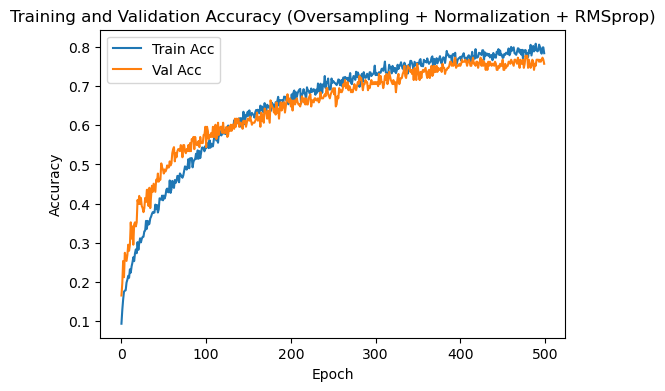

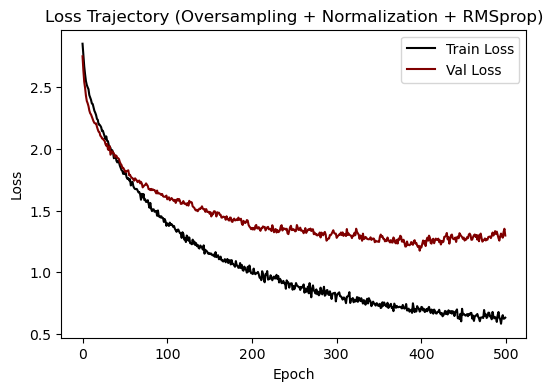

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


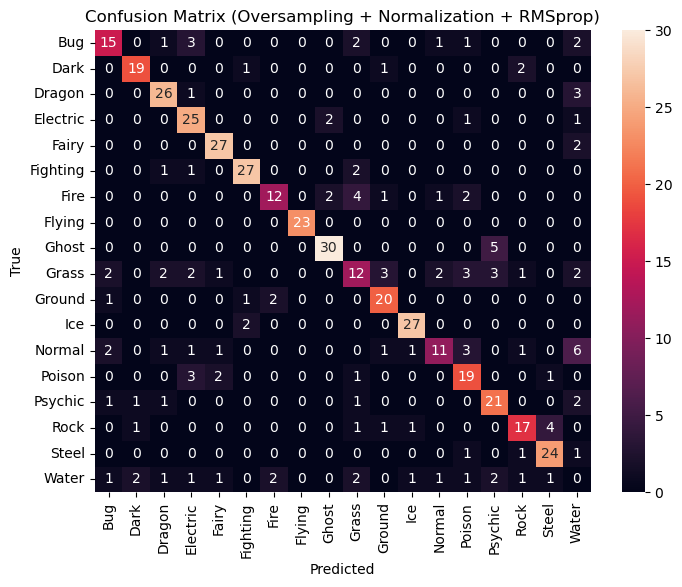

              precision    recall  f1-score   support

         Bug       0.68      0.60      0.64        25
        Dark       0.83      0.83      0.83        23
      Dragon       0.79      0.87      0.83        30
    Electric       0.68      0.86      0.76        29
       Fairy       0.84      0.93      0.89        29
    Fighting       0.87      0.87      0.87        31
        Fire       0.75      0.55      0.63        22
      Flying       1.00      1.00      1.00        23
       Ghost       0.88      0.86      0.87        35
       Grass       0.48      0.36      0.41        33
      Ground       0.74      0.83      0.78        24
         Ice       0.90      0.93      0.92        29
      Normal       0.69      0.39      0.50        28
      Poison       0.61      0.73      0.67        26
     Psychic       0.68      0.78      0.72        27
        Rock       0.74      0.68      0.71        25
       Steel       0.80      0.89      0.84        27
       Water       0.00    

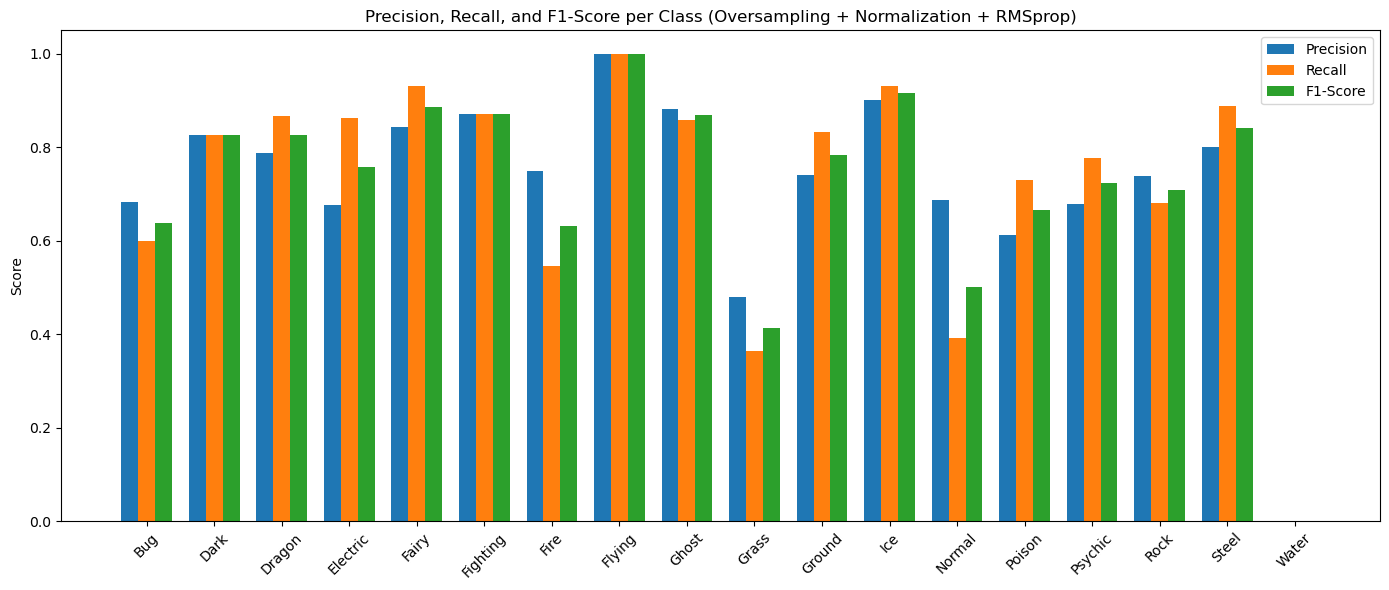

In [ ]:
# Model for oversampling and normalization with RMSprop
model = build_model(optimizer_name = "rmsprop", input_shape = x3.shape[1])
train_and_evaluate(model, x3, y3, label_encoder3, title_suffix = "(Oversampling + Normalization + RMSprop)")

All models at 500 epochs do not converge. The models with the best results are SGD (no momentum) and adagrad, which may converge if allowed to run for up to 1000 epochs:

Epoch 1/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0522 - loss: 2.9201 - val_accuracy: 0.0674 - val_loss: 2.8962
Epoch 2/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0581 - loss: 2.9205 - val_accuracy: 0.0777 - val_loss: 2.8892
Epoch 3/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0493 - loss: 2.9267 - val_accuracy: 0.0777 - val_loss: 2.8832
Epoch 4/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0798 - loss: 2.8916 - val_accuracy: 0.0777 - val_loss: 2.8780
Epoch 5/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0596 - loss: 2.8997 - val_accuracy: 0.0725 - val_loss: 2.8737
Epoch 6/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0618 - loss: 2.8947 - val_accuracy: 0.0829 - val_loss: 2.8685
Epoch 7/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0656 - loss: 2.8870 - val_accuracy: 0.0984 - val_loss: 2.8638
Epoch 8/5000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0846 - loss: 2.8812 - val_accuracy: 0

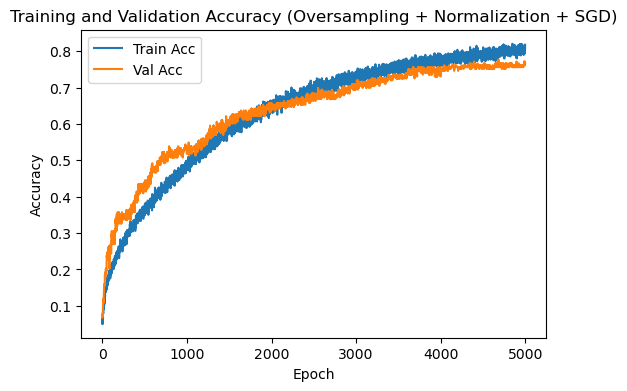

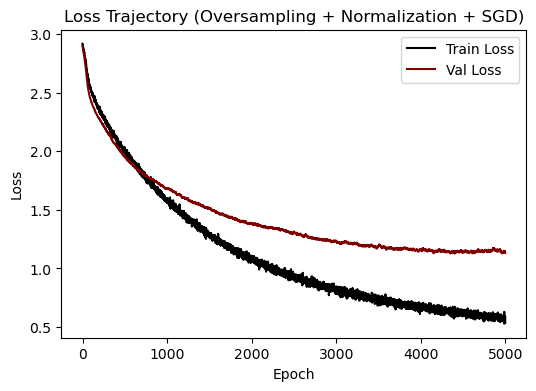

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


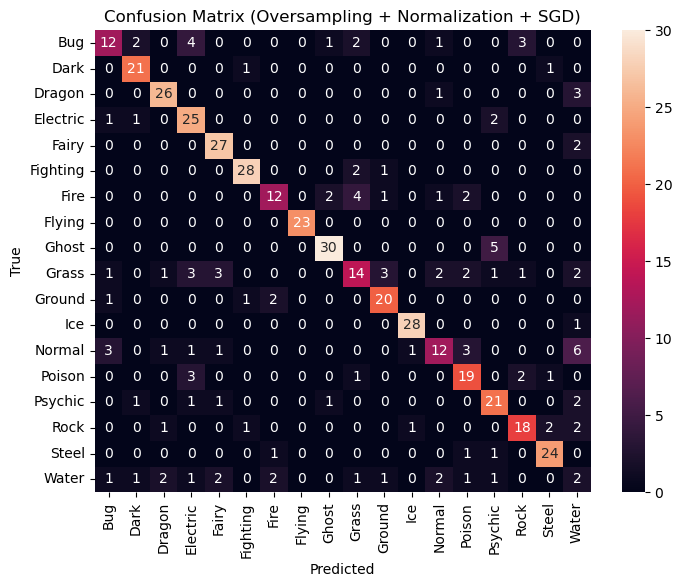

              precision    recall  f1-score   support

         Bug       0.63      0.48      0.55        25
        Dark       0.81      0.91      0.86        23
      Dragon       0.84      0.87      0.85        30
    Electric       0.66      0.86      0.75        29
       Fairy       0.79      0.93      0.86        29
    Fighting       0.90      0.90      0.90        31
        Fire       0.71      0.55      0.62        22
      Flying       1.00      1.00      1.00        23
       Ghost       0.88      0.86      0.87        35
       Grass       0.58      0.42      0.49        33
      Ground       0.77      0.83      0.80        24
         Ice       0.93      0.97      0.95        29
      Normal       0.63      0.43      0.51        28
      Poison       0.68      0.73      0.70        26
     Psychic       0.68      0.78      0.72        27
        Rock       0.75      0.72      0.73        25
       Steel       0.86      0.89      0.87        27
       Water       0.10    

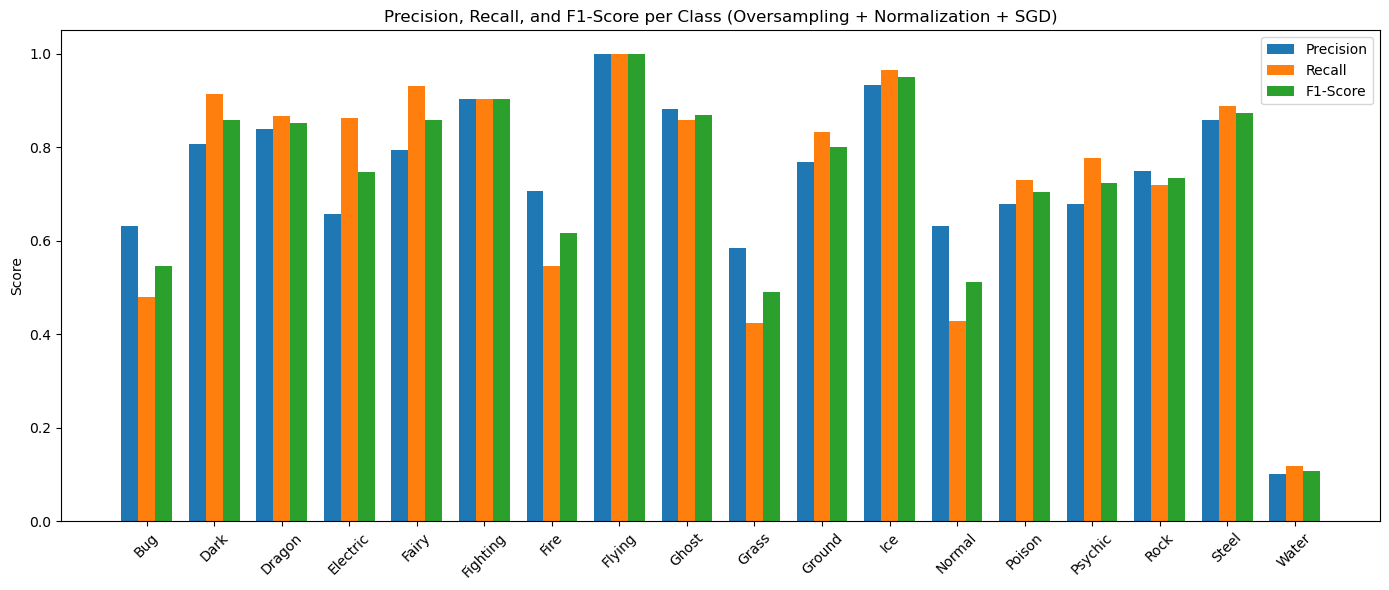

In [ ]:
# Model with oversampling and normalization with SGD at 5000 epochs

model = build_model(optimizer_name = "sgd", input_shape = x3.shape[1])
train_and_evaluate(model, x3, y3, label_encoder3, title_suffix = "(Oversampling + Normalization + SGD)", numEpochs = 5000)

Epoch 1/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0675 - loss: 2.9085 - val_accuracy: 0.0570 - val_loss: 2.9062
Epoch 2/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0677 - loss: 2.8983 - val_accuracy: 0.0570 - val_loss: 2.9041
Epoch 3/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0693 - loss: 2.8968 - val_accuracy: 0.0674 - val_loss: 2.9020
Epoch 4/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0638 - loss: 2.9015 - val_accuracy: 0.0674 - val_loss: 2.9000
Epoch 5/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0603 - loss: 2.9005 - val_accuracy: 0.0622 - val_loss: 2.8980
Epoch 6/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0623 - loss: 2.9010 - val_accuracy: 0.0674 - val_loss: 2.8960
Epoch 7/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0646 - loss: 2.8958 - val_accuracy: 0.0777 - val_loss: 2.8942
Epoch 8/20000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0621 - loss: 2.8949 - val_ac

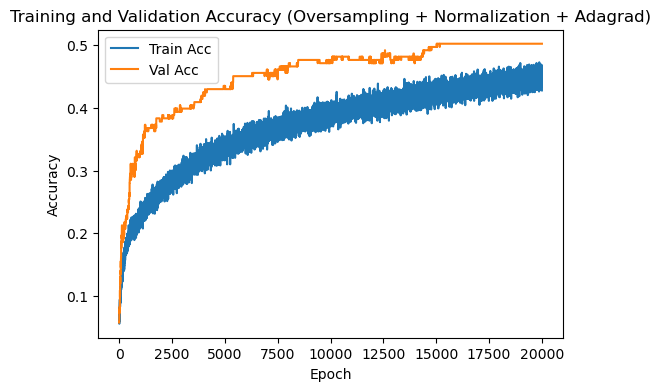

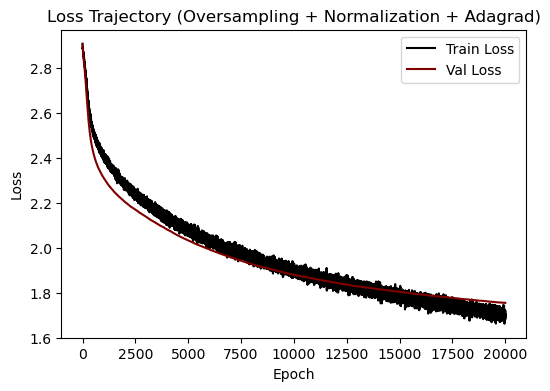

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


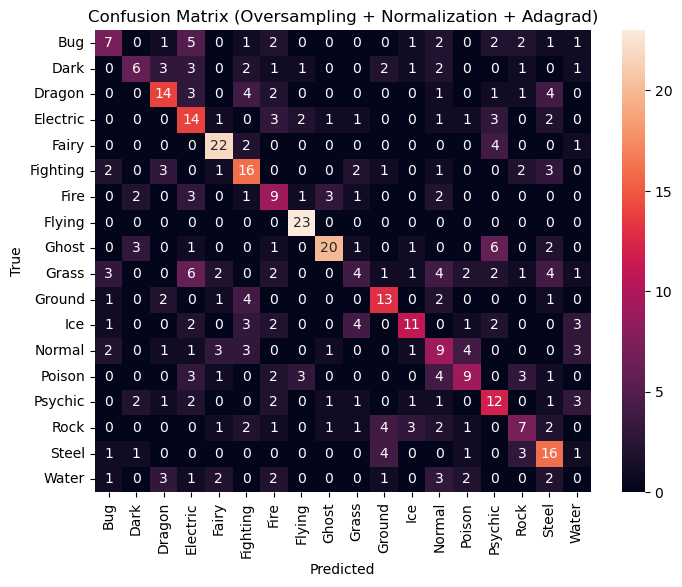

              precision    recall  f1-score   support

         Bug       0.39      0.28      0.33        25
        Dark       0.43      0.26      0.32        23
      Dragon       0.50      0.47      0.48        30
    Electric       0.32      0.48      0.38        29
       Fairy       0.65      0.76      0.70        29
    Fighting       0.42      0.52      0.46        31
        Fire       0.31      0.41      0.35        22
      Flying       0.77      1.00      0.87        23
       Ghost       0.74      0.57      0.65        35
       Grass       0.27      0.12      0.17        33
      Ground       0.50      0.54      0.52        24
         Ice       0.55      0.38      0.45        29
      Normal       0.26      0.32      0.29        28
      Poison       0.43      0.35      0.38        26
     Psychic       0.38      0.44      0.41        27
        Rock       0.35      0.28      0.31        25
       Steel       0.41      0.59      0.48        27
       Water       0.00    

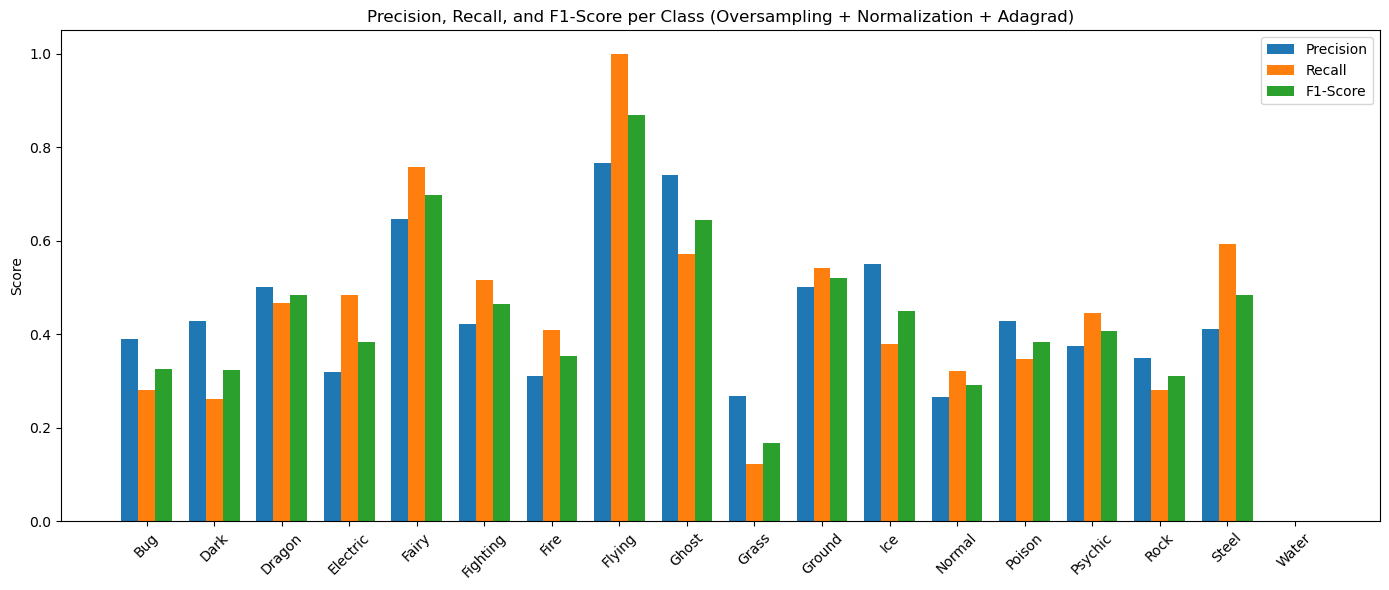

In [51]:
# Model with oversampling and normalization with Adagrad at 20000 epochs
model = build_model(optimizer_name = "adagrad", input_shape = x3.shape[1])
train_and_evaluate(model, x3, y3, label_encoder3, title_suffix = "(Oversampling + Normalization + Adagrad)", numEpochs = 20000)